# Classification task:

In this notebook,first, I prepared the data for the classifiers, i.e., 

* test/train split (20/80) 
* transformed the data into standard scalar.
* hot-one code the composer categories

I have written useful functions to report the the metrics of each models, these metrics include:

* F1score
* Accuracy
* Hammer Loss
* Error rate for each class using confusion matrix
* area under the Receiver operating Characteristic (ROC) curve


I have implemented the following classifiers using Sckit-learn package:

* XGBoost
* SVM Linear : one vs one and one vs rest
* SVM non linear (`rbf` kernel)
* logistic regression (with cross validations)
* Random forest
* Multilabel KNN (with grid search)
* MLP 


I have evaluated all these models for the 60 seconds chunks, the best model turned out to be `XGBoost`. Also, `MLP` worked better than other models but not better than `XGBoost`, not even after some hyper parameter tuning. 
Then, I tried to improve `XGBoost` using grid search on `gamma`, `tree` and `subsample`rate. Using accuracy as a measure, the model did not improve. The best parameters were `gamma`=0,`subsample=1`, which are the default values. Changing `tree` method does not change accuracy.

I have calculated the time each model takes to get trained and to predict. `XGBoost` is among the fasted models. 

I have implemented `XGBoost` classifier on 15 and 30 seconds chunk. By decreasing the chunks duration, most classes will get higher error rate.
Therefore, I used the `XGBoost` classifer trained on 60 seconds to predict the unseen data, which are the songs in the **PS2** folder. The implementation of predicting and mapping is at the end of this notebook. 

The final ***error rate for each class*** is :

**Bach: 0.032**

**Beethoven: 0.044**

**Brahms: 0.081**

**Schubert: 0.039**


In [329]:
# general libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')

# classification
from skmultilearn.adapt import MLkNN
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.neural_network import MLPClassifier


from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold,GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report, ConfusionMatrixDisplay


In [7]:
path = '....\\data\\PS1\\'

# Preparing the model

## reading the data

In [415]:
# reading 3 sets of data and appending them into a list
chunks = [15,30,60]
data_list = []
for ch in chunks:
    data = pd.read_csv(path+'note_chunk_cleaned_'+str(ch)+'.csv', index_col = [0])
    # hot-one code the composer label for multilabel classification
    data = pd.get_dummies(data, columns = ['composer_label'])
    # no need for trackid column anymore
    del data['trackid']
    # append the data to the list
    data_list.append(data)
    

In [416]:
len(data_list[0]),len(data_list[1]),len(data_list[2])

(8507, 4310, 2156)

## train, test builder 

In [386]:
# Train,Test split function
def Xy_build(data):
    # 4 classes of music 
    y = data [data.columns[165:]]
    # features including 86 note repeat and 86 note duration, TPQ
    X = data [data.columns[:165]]
    # splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=88)
    scaler = preprocessing.StandardScaler().fit(X_train)
    # transforming the data to unify the scale
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    return X_train_sc,y_train,X_test_sc,y_test


## scores reporter

In [189]:
def model_score_reports(model,model_name,X,y):
    # predicting the y using classifier
    y_hat = model.predict(X)
    # hammer loss metric
    br_hamm=metrics.hamming_loss(y,y_hat)
    # accuracy
    accuracy = metrics.accuracy_score(y, y_hat)
    # f1 scoro at macro and micro level
    f1_score_micro = metrics.f1_score(y, y_hat, average='micro')
    f1_score_macro = metrics.f1_score(y, y_hat, average='macro')
    # printing the report
    print(model_name+' Accuracy Score:',round(accuracy,3))
    print(model_name+' F1-score macro:',round(f1_score_macro,3))
    print(model_name+' F1-score micro:',round(f1_score_micro,3))
    print(model_name+' Hamming Loss:',round(br_hamm,3))
    print(classification_report(y, y_hat))
    

## area under the ROC curve reporter

In [351]:
### area under the Receiver operating characteristic (ROC) curve 
def roc_auc_report(model,X,y,labels=['Bach','Beethoven','Brahms','Schubert']):
    # predicting the y using classifier
    y_hat = model.predict(X)
    # loop over each category
    for i,label in enumerate(labels):
        roc_auc_ = metrics.roc_auc_score(y.to_numpy()[:,i],y_hat[:,i])
        print("ROC AUC %s: %.2f" % (label,roc_auc_))

## confusion matrix displayer with error rate

In [455]:
# error rate for each class function
def error_rate(confusion_matrix):
    error = 1-np.sum(np.trace(confusion_matrix))/np.sum(confusion_matrix)
    return error
# confusion matrix display
def confusion_matrix_display(model,X,y,labels=['Bach','Beethoven','Brahms','Schubert']):
    # predicting the y using classifier
    y_hat = model.predict(X)
    # creating confusion matrix for all labels
    cm = mcm(y, y_hat)
    # initializing the subplot
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        # get the error rate
        error_r = error_rate(cm[i])
        # get the confusion matrix plot using `ConfusionMatrixDisplay` function
        cmd = ConfusionMatrixDisplay(cm[i], display_labels=[labels[i],'rest'])
        cmd.plot(ax=ax)
        cmd.ax_.set(xlabel='Predicted', ylabel='True', title='error rate ='+str(np.round(error_r,3)))
        cmd.im_.colorbar.remove()

In [466]:
# bulding the data for 60 seconds chunks
X_train_sc,y_train,X_test_sc,y_test = Xy_build(data_list[2])

# XGBoost

In [467]:
# get the start time
start=time.time()
# creating the classifier
XGBoost = MultiOutputClassifier(XGBClassifier(eval_metric='logloss'))
clf = Pipeline([('classify', XGBoost)])
# training the classifier
clf.fit(X_train_sc, y_train)
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
# print(clf)
# predicting the test set
y_hat = clf.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')


training time taken:  1.0 seconds
prediction time taken:  0.0 seconds


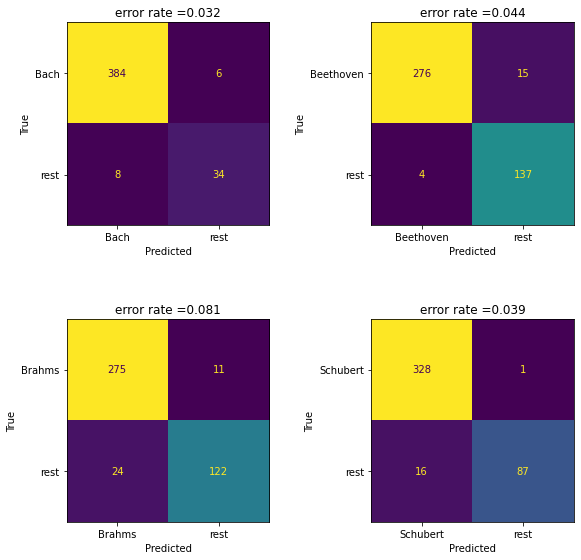

In [468]:
confusion_matrix_display(clf,X_test_sc,y_test)

In [392]:
model_score_reports(clf,'XGBoost',X_test_sc,y_test)

XGBoost Accuracy Score: 0.87
XGBoost F1-score macro: 0.89
XGBoost F1-score micro: 0.902
XGBoost Hamming Loss: 0.048
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        42
           1       0.90      0.97      0.93       141
           2       0.92      0.84      0.88       146
           3       0.99      0.85      0.92       103

   micro avg       0.92      0.88      0.90       432
   macro avg       0.91      0.87      0.89       432
weighted avg       0.92      0.88      0.90       432
 samples avg       0.88      0.88      0.88       432



In [393]:
# area under the ROC curve
roc_auc_report(clf,X_test_sc,y_test)

ROC AUC Bach: 0.90
ROC AUC Beethoven: 0.96
ROC AUC Brahms: 0.90
ROC AUC Schubert: 0.93


# OneVsRest SVM Linear

In [394]:
# get the start time
start=time.time()
# Create the SVM Linear class OneVsRest
OVR_SVM = OneVsRestClassifier(SVC(kernel="linear"))
# Fit the data to the classifier
OVR_SVM.fit(X_train_sc, y_train)
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
# predict
y_hat = OVR_SVM.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# report
model_score_reports(OVR_SVM,'SVM Linear OneVsRest',X_test_sc,y_test)

training time taken:  3.0 seconds
prediction time taken:  0.0 seconds
SVM Linear OneVsRest Accuracy Score: 0.412
SVM Linear OneVsRest F1-score macro: 0.468
SVM Linear OneVsRest F1-score micro: 0.539
SVM Linear OneVsRest Hamming Loss: 0.198
              precision    recall  f1-score   support

           0       0.43      0.14      0.21        42
           1       0.61      0.71      0.66       141
           2       0.69      0.34      0.45       146
           3       0.74      0.44      0.55       103

   micro avg       0.65      0.46      0.54       432
   macro avg       0.62      0.41      0.47       432
weighted avg       0.65      0.46      0.52       432
 samples avg       0.44      0.46      0.45       432



# OneVsOne SVM Linear

In [395]:
# get the start time
start=time.time()
classes = ['Bach','Beethoven','Brahms','Schubert']
#loop over classes
for i,label in enumerate(classes):
    # Create the SVM Linear class OneVsOne
    OVO_SVM = OneVsOneClassifier(SVC(kernel="linear"))
    # fit the training data to classifier
    OVO_SVM.fit(X_train_sc, y_train.to_numpy()[:,i])
    # training time
    print('training time taken: ',round(time.time()-start,0),'seconds')
    # get the start time
    start=time.time()
    # predict on test set
    y_hat = OVO_SVM.predict(X_test_sc)
    # predicting time 
    print('prediction time taken: ',round(time.time()-start,0),'seconds')
    # report on each class
    print('report scores for '+label+' class:')
    model_score_reports(OVO_SVM,'SVM Linear OneVsOne',X_test_sc,y_test.to_numpy()[:,i])


training time taken:  0.0 seconds
prediction time taken:  0.0 seconds
report scores for Bach class:
SVM Linear OneVsOne Accuracy Score: 0.898
SVM Linear OneVsOne F1-score macro: 0.58
SVM Linear OneVsOne F1-score micro: 0.898
SVM Linear OneVsOne Hamming Loss: 0.102
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       390
           1       0.43      0.14      0.21        42

    accuracy                           0.90       432
   macro avg       0.67      0.56      0.58       432
weighted avg       0.87      0.90      0.87       432

training time taken:  1.0 seconds
prediction time taken:  0.0 seconds
report scores for Beethoven class:
SVM Linear OneVsOne Accuracy Score: 0.757
SVM Linear OneVsOne F1-score macro: 0.734
SVM Linear OneVsOne F1-score micro: 0.757
SVM Linear OneVsOne Hamming Loss: 0.243
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       291
           1       0.61     

# SVM non-linear 

In [396]:
# get the start time
start=time.time()
# creating the SVM with non-linear kernel
classif = SVC(kernel='rbf',gamma='auto')
SVM_nonlineaer = MultiOutputClassifier(classif, n_jobs=-1)
# training the classifier
SVM_nonlineaer.fit(X_train_sc, y_train)
# training time
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
y_hat = SVM_nonlineaer.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')
model_score_reports(SVM_nonlineaer,'SVM non linear',X_test_sc,y_test)


prediction time taken:  1.0 seconds
prediction time taken:  1.0 seconds
SVM non linear Accuracy Score: 0.438
SVM non linear F1-score macro: 0.448
SVM non linear F1-score micro: 0.565
SVM non linear Hamming Loss: 0.171
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        42
           1       0.69      0.71      0.70       141
           2       0.86      0.41      0.56       146
           3       0.94      0.29      0.44       103

   micro avg       0.77      0.44      0.56       432
   macro avg       0.87      0.36      0.45       432
weighted avg       0.84      0.44      0.53       432
 samples avg       0.44      0.44      0.44       432



# Logistic Regression with Cross Validation

In [397]:
# get the start time
start=time.time()
# creating the logistic regression with 5 fold for multilabel classificatio
LogReg = LogisticRegressionCV(cv=5,multi_class ='ovr', random_state=42)
LogReg_multi = MultiOutputClassifier(LogReg, n_jobs=-1)
# training the data with the classifier
LogReg_multi.fit(X_train_sc, y_train)
# training time
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
# predicting the test data
y_hat = LogReg_multi.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# report
model_score_reports(LogReg_multi,'Logistic Regression',X_test_sc,y_test)

prediction time taken:  2.0 seconds
prediction time taken:  0.0 seconds
Logistic Regression Accuracy Score: 0.375
Logistic Regression F1-score macro: 0.455
Logistic Regression F1-score micro: 0.52
Logistic Regression Hamming Loss: 0.204
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        42
           1       0.57      0.66      0.61       141
           2       0.75      0.29      0.42       146
           3       0.68      0.48      0.56       103

   micro avg       0.63      0.44      0.52       432
   macro avg       0.63      0.39      0.45       432
weighted avg       0.65      0.44      0.50       432
 samples avg       0.41      0.44      0.42       432



# Random Forest

In [400]:
# get the start time
start=time.time()
# creating the random foreset classfier
RandomForest = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)
# training the data with the classifier
RandomForest.fit(X_train_sc, y_train)
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
# predicting on the test set
y_hat=RandomForest.predict(X_test_sc)
# predicting time
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# report
model_score_reports(RandomForest,'Random Foreset',X_test_sc,y_test)

training time taken:  3.0 seconds
prediction time taken:  0.0 seconds
Random Foreset Accuracy Score: 0.692
Random Foreset F1-score macro: 0.757
Random Foreset F1-score micro: 0.794
Random Foreset Hamming Loss: 0.09
              precision    recall  f1-score   support

           0       0.91      0.48      0.62        42
           1       0.90      0.85      0.87       141
           2       0.92      0.66      0.77       146
           3       1.00      0.61      0.76       103

   micro avg       0.93      0.69      0.79       432
   macro avg       0.93      0.65      0.76       432
weighted avg       0.93      0.69      0.79       432
 samples avg       0.69      0.69      0.69       432



# MultiLabel KNN with Grid Search

In [404]:
# Grid search parameters
parameters = {'k': range(1,4), 's': [0.2,0.5, 0.7, 1.0]}
# evaluation metric
score = 'f1_micro'
# get the start time
start=time.time()
# creating the classifier
classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
# training data with the classifier
classifier.fit(X_train.to_numpy(), y_train.to_numpy())
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
print('best parameters :', classifier.best_params_, 'best score: ',
      classifier.best_score_)

training time taken:  44.0 seconds
best parameters : {'k': 1, 's': 0.2} best score:  0.5881563869228177


# MLP classifier

In [405]:
# get the time 
start=time.time()
# creat the MLP classifier
MLP = MLPClassifier(learning_rate='constant',random_state=42, max_iter=1000)
MLP_multi = MultiOutputClassifier(MLP, n_jobs=-1)
# training the data with the classifier
MLP_multi.fit(X_train_sc, y_train)
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
# get the time 
start=time.time()
# predicting the test data
y_hat = MLP_multi.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# report
model_score_reports(MLP_multi,'Logistic Regression',X_test_sc,y_test)

training time taken:  7.0 seconds
prediction time taken:  0.0 seconds
Logistic Regression Accuracy Score: 0.655
Logistic Regression F1-score macro: 0.735
Logistic Regression F1-score micro: 0.756
Logistic Regression Hamming Loss: 0.12
              precision    recall  f1-score   support

           0       0.65      0.67      0.66        42
           1       0.75      0.84      0.80       141
           2       0.81      0.73      0.77       146
           3       0.81      0.65      0.72       103

   micro avg       0.77      0.74      0.76       432
   macro avg       0.76      0.72      0.74       432
weighted avg       0.78      0.74      0.75       432
 samples avg       0.70      0.74      0.71       432



In [406]:
labels = ['Bach','Beethoven','Brahms','Schubert']
# loop over each category
for i,label in enumerate(labels):
    roc_auc_ = metrics.roc_auc_score(y_test.to_numpy()[:,i],y_hat[:,i])
    print("ROC AUC %s: %.2f" % (label,roc_auc_))

ROC AUC Bach: 0.81
ROC AUC Beethoven: 0.85
ROC AUC Brahms: 0.82
ROC AUC Schubert: 0.80


# XGBoost hyperparametr tuning

In [407]:
# get the time
start = time.time()
# making grid for gamma and subsample values
arrays = [[0, 0, 0,
           5, 5, 5,
           50, 50, 50],
          [.33, .67, 1,
           .33, .67, 1,
           .33, .67, 1]]
XGBdf = pd.DataFrame(index = arrays,
                     columns = ["exact", "approx", "hist"],
                     dtype = "float")

# Iterate through every gamma
for gamma in [0, 5, 50]:
    print("gamma = ", gamma)
    # Iterate through every subsample size
    for subsample in [.33, .67, 1]:
        # Then iterate through each tree method
        for method in list(XGBdf.columns):
            alr_xgboost = MultiOutputClassifier(XGBClassifier(max_depth = 5,
                                            gamma = gamma,
                                            subsample = subsample,
                                            tree_method = method, eval_metric='logloss'))
            alr_xgboost.fit(X_train_sc, y_train)
            yhat= alr_xgboost.predict(X_test_sc)
            accuracy = metrics.accuracy_score(y_test, yhat) * 100
            XGBdf.loc[(gamma,  subsample), method] = accuracy
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')

gamma =  0
gamma =  5
gamma =  50
training time taken:  59.0 seconds


In [408]:
display(XGBdf)

exact     approx       hist
0  0.33  81.944444  81.944444  82.175926
   0.67  84.722222  83.796296  83.101852
   1.00  85.879630  86.342593  86.342593
5  0.33  80.092593  80.092593  81.018519
   0.67  82.870370  82.407407  84.259259
   1.00  82.407407  83.796296  81.481481
50 0.33  59.027778  58.101852  59.027778
   0.67  61.111111  63.888889  63.425926
   1.00  64.583333  64.583333  64.351852

# XGBoost for 30 and 15 seconds chunk

In [457]:
# 30 seconds 
# bulding the data for 30 seconds chunks
X_train_sc,y_train,X_test_sc,y_test = Xy_build(data_list[1])
# get the start time
start=time.time()
# creating the classifier
XGBoost = MultiOutputClassifier(XGBClassifier(eval_metric='logloss'))
clf = Pipeline([('classify', XGBoost)])
# training the classifier
clf.fit(X_train_sc, y_train)
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
# print(clf)
# predicting the test set
y_hat = clf.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# area under the ROC curve
roc_auc_report(clf,X_test_sc,y_test)

training time taken:  2.0 seconds
prediction time taken:  0.0 seconds
ROC AUC Bach: 0.92
ROC AUC Beethoven: 0.93
ROC AUC Brahms: 0.90
ROC AUC Schubert: 0.93


In [458]:
model_score_reports(clf,'XGBoost',X_test_sc,y_test)

XGBoost Accuracy Score: 0.858
XGBoost F1-score macro: 0.895
XGBoost F1-score micro: 0.895
XGBoost Hamming Loss: 0.052
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        93
           1       0.89      0.93      0.91       312
           2       0.89      0.85      0.87       281
           3       0.93      0.88      0.91       176

   micro avg       0.91      0.89      0.90       862
   macro avg       0.91      0.88      0.89       862
weighted avg       0.91      0.89      0.89       862
 samples avg       0.87      0.89      0.88       862



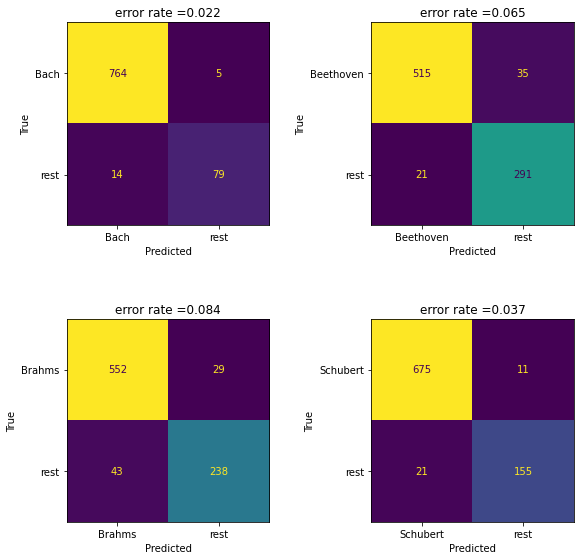

In [459]:
confusion_matrix_display(clf,X_test_sc,y_test)

In [460]:
# 15 seconds 
# bulding the data for 30 seconds chunks
X_train_sc,y_train,X_test_sc,y_test = Xy_build(data_list[0])
# get the start time
start=time.time()
# creating the classifier
XGBoost = MultiOutputClassifier(XGBClassifier(eval_metric='logloss'))
clf = Pipeline([('classify', XGBoost)])
# training the classifier
clf.fit(X_train_sc, y_train)
# training time
print('training time taken: ',round(time.time()-start,0),'seconds')
# get the start time
start=time.time()
# print(clf)
# predicting the test set
y_hat = clf.predict(X_test_sc)
# predicting time 
print('prediction time taken: ',round(time.time()-start,0),'seconds')
# area under the ROC curve
roc_auc_report(clf,X_test_sc,y_test)

training time taken:  4.0 seconds
prediction time taken:  0.0 seconds
ROC AUC Bach: 0.90
ROC AUC Beethoven: 0.92
ROC AUC Brahms: 0.88
ROC AUC Schubert: 0.92


In [461]:
model_score_reports(clf,'XGBoost',X_test_sc,y_test)

XGBoost Accuracy Score: 0.834
XGBoost F1-score macro: 0.873
XGBoost F1-score micro: 0.873
XGBoost Hamming Loss: 0.062
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       156
           1       0.86      0.91      0.88       585
           2       0.89      0.81      0.85       584
           3       0.95      0.86      0.91       377

   micro avg       0.89      0.86      0.87      1702
   macro avg       0.90      0.85      0.87      1702
weighted avg       0.89      0.86      0.87      1702
 samples avg       0.84      0.86      0.85      1702



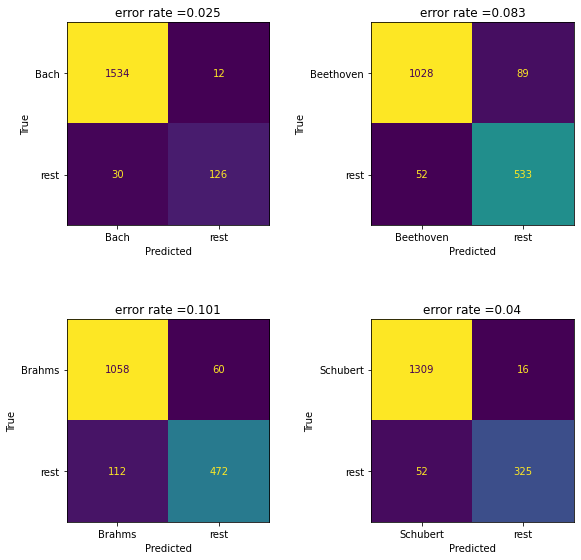

In [462]:
confusion_matrix_display(clf,X_test_sc,y_test)

# PS2: reading Unseen Data 
only chunk 60 since we got a lower error rate




In [501]:
path = "....\data\\"
data = pd.read_csv(path+'note_chunk_cleaned_test_60.csv', index_col = [0])
# we need trackid for mapping the file number into the predicted category later
# del data['trackid']
# append the data to the list    

In [521]:
# we need file names for mapping
file_names = ['0.002716920481628_adj.mid',
 '0.033313986422223163_adj.mid',
 '0.047574444458241216_adj.mid',
 '0.06402123326764841_adj.mid',
 '0.07186746659481313_adj.mid',
 '0.09167358800381353_adj.mid',
 '0.10222964826466285_adj.mid',
 '0.10250888365879718_adj.mid',
 '0.10630249969742178_adj.mid',
 '0.1755252422917658_adj.mid',
 '0.1960551158929671_adj.mid',
 '0.21198476749665085_adj.mid',
 '0.21901852969811753_adj.mid',
 '0.22047111832936944_adj.mid',
 '0.23120017256495873_adj.mid',
 '0.26551079719260606_adj.mid',
 '0.30993012400290976_adj.mid',
 '0.3264565808984162_adj.mid',
 '0.3334293069825759_adj.mid',
 '0.33695573887576447_adj.mid',
 '0.337517805339117_adj.mid',
 '0.3559970176888735_adj.mid',
 '0.3620067189216978_adj.mid',
 '0.36321860283443286_adj.mid',
 '0.48367685897240176_adj.mid',
 '0.539512676743813_adj.mid',
 '0.549470161204349_adj.mid',
 '0.5807329043589801_adj.mid',
 '0.647959423719129_adj.mid',
 '0.7491289879531658_adj.mid',
 '0.8014751784512073_adj.mid',
 '0.905499891236923_adj.mid',
 '0.9353908329958764_adj.mid',
 '0.9511403301279795_adj.mid',
 '0.981087291054314_adj.mid']

# predicting the unseen daat

In [502]:
# preparing the features
prediction_features = list(data.columns[:164])+['TPQ']
len(prediction_features)
# preparing the data : standard scalar
X_unseen_sc = scaler.transform(data[prediction_features])

In [486]:
# predicting using the first XGBboost model
y_hat = clf.predict(X_unseen_sc)

# mapping the predictions into the original file

In [510]:
for i in range(len(y_hat)):
    index_class = np.where(y_hat[i]==1)[0]
    if index_class.any():
        if index_class[0] == 0:
            print('Bach')
            data.loc[i,'composer_label'] = 'Bach'
        elif index_class[0] == 1:
            print('Beethoven')
            data.loc[i,'composer_label'] = 'Beethoven'
        elif index_class[0] == 2:
            print('Brahms')
            data.loc[i,'composer_label'] = 'Brahms'
        elif index_class[0] == 3:
            print('Schubert')
            data.loc[i,'composer_label'] = 'Schubert'
    else:
        data.loc[i,'composer_label'] = 'Unknown'

Bach
Brahms
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Schubert
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Brahms
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
Beethoven
B

In [522]:
# mapping the file numbers with predicted composer label
final_dictionary = dict()
for group in data.groupby(['trackid']):
    trackid = group[0]
    file_index = trackid.split('_')[0]
    mod = group[1].composer_label.mode()
    print(file_index,file_names[int(file_index)],list(mod))
    

0 0.002716920481628_adj.mid ['Unknown']
0 0.002716920481628_adj.mid ['Unknown']
0 0.002716920481628_adj.mid ['Unknown']
0 0.002716920481628_adj.mid ['Unknown']
10 0.1960551158929671_adj.mid ['Unknown']
10 0.1960551158929671_adj.mid ['Unknown']
10 0.1960551158929671_adj.mid ['Unknown']
11 0.21198476749665085_adj.mid ['Schubert']
11 0.21198476749665085_adj.mid ['Schubert']
11 0.21198476749665085_adj.mid ['Schubert']
11 0.21198476749665085_adj.mid ['Schubert']
12 0.21901852969811753_adj.mid ['Schubert']
12 0.21901852969811753_adj.mid ['Schubert']
12 0.21901852969811753_adj.mid ['Schubert']
12 0.21901852969811753_adj.mid ['Schubert']
13 0.22047111832936944_adj.mid ['Unknown']
13 0.22047111832936944_adj.mid ['Unknown']
13 0.22047111832936944_adj.mid ['Unknown']
13 0.22047111832936944_adj.mid ['Unknown']
14 0.23120017256495873_adj.mid ['Beethoven']
14 0.23120017256495873_adj.mid ['Beethoven']
14 0.23120017256495873_adj.mid ['Beethoven']
14 0.23120017256495873_adj.mid ['Beethoven']
15 0.26551